In [21]:
import sys
sys.path.append("/home/wanxinli/EHR-OT/")

import matplotlib.pyplot as plt
from mimic_common import *
import os
import pandas as pd

In [22]:
trans_metrics = ['OT', 'TCA', 'MMD']
score_dir = "/home/wanxinli/EHR-OT/outputs/mimic/"

# group_name = 'insurance'
# group_1 = 'Medicaid'
# group_2 = 'Self_Pay'

# group_name = 'gender'
# group_1 = 'M'
# group_2 = 'F'

group_name = 'ethnicity'
group_1 = 'WHITE'
# group_2 = 'HISPANIC_OR_LATINO'
group_2 = 'ASIAN'

In [23]:

def ratios_for_metrics(eval_metric, trans_metrics):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str eval_metric: evaluation metric, mae or rmse
    :param str trans_metric: transporting metric, OT, TCA or MMD
    """

    metric_improve_ratios = []
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"exp4_{group_name}_{group_2}2{group_1}_{trans_metric}.csv")
        score_df = pd.read_csv(score_path, header=0, index_col=0)

        # compute improvements in terms of ratio
        metric_improve_ratios.append(compute_metric_ratio(score_df, eval_metric))

    return metric_improve_ratios


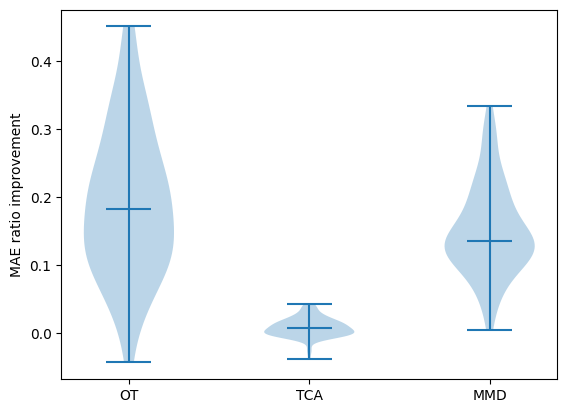

In [24]:
mae_improve_ratios = ratios_for_metrics('mae', trans_metrics)

# Pandas dataframe
data = pd.DataFrame({
    trans_metrics[0]: mae_improve_ratios[0],
    trans_metrics[1]: mae_improve_ratios[1], 
    trans_metrics[2]: mae_improve_ratios[2]
})

# Plot the dataframe
plt.violinplot(data, showmedians=True)
plt.xticks([1, 2, 3], labels=['OT', 'TCA', 'MMD'])
plt.ylabel("MAE ratio improvement")
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_MAE.pdf")
plt.savefig(fig_path)
plt.show()



          OT       TCA       MMD
0  -0.082635  0.000522  0.010186
1   0.108250  0.000488  0.048961
2   0.126851  0.009317  0.049466
3   0.160948  0.011127  0.092222
4   0.229938  0.004917  0.189671
..       ...       ...       ...
95  0.232259  0.013245  0.200142
96  0.456649  0.013659  0.289501
97  0.036392 -0.006266  0.137512
98  0.119927 -0.014583  0.149882
99  0.222532  0.032138  0.175471

[100 rows x 3 columns]


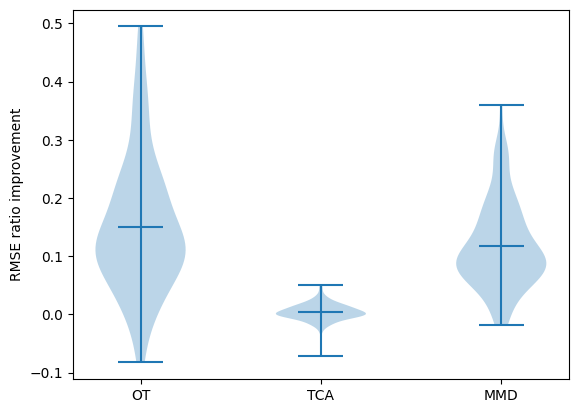

In [25]:
rmse_improve_ratios = ratios_for_metrics('rmse', trans_metrics)

# Pandas dataframe
data = pd.DataFrame({
    trans_metrics[0]: rmse_improve_ratios[0],
    trans_metrics[1]: rmse_improve_ratios[1], 
    trans_metrics[2]: rmse_improve_ratios[2]
})
print(data)

# Plot the dataframe
plt.violinplot(data, showmeans=True)
plt.xticks([1, 2, 3], labels=['OT', 'TCA', 'MMD'])
plt.ylabel("RMSE ratio improvement")
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_RMSE.pdf")
plt.savefig(fig_path)
plt.show()

